# U-Net Model - Orbital Response

In [125]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from PIL import Image

## Model Initialisation

### The Encoder

In [126]:
# Load pre-trained ResNet34 model
resnet34 = models.resnet34(pretrained=True)

In [ ]:
resnet34.conv1 = nn.Conv2d(
    in_channels=6,   # 6 for pre + post RGB images
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

In [128]:
resnet34

ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [129]:
# Freezing all parameters in the pretrained model, other than those in the first layer (that have been trained)
for name, param in resnet34.named_parameters():
    if name.startswith('conv1'):
        param.requires_grad = True
    else:
        param.requires_grad = False

### The Decoder

In [130]:
# A function defining the convolution block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    )

### Combining the Decorder to Form the U-Net

The **forward()** function defines the data flow through your model — it's how the model transforms input data into an output using its layers.

In [131]:
# Defining the U-Net model class
class UNetModel(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()

        # Encoder (modified for 6-channel input)
        self.encoder = resnet34

        # Decoder blocks
        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec5 = conv_block(512 + 256, 256)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec4 = conv_block(256 + 128, 128)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = conv_block(128 + 64, 64)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = conv_block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        e2 = self.encoder.layer1(self.encoder.maxpool(e1))
        e3 = self.encoder.layer2(e2)
        e4 = self.encoder.layer3(e3)
        e5 = self.encoder.layer4(e4)

        d5 = self.dec5(torch.cat([self.up5(e5), e4], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d5), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e1], dim=1))

        out = self.final_conv(d2)
        return F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=False)


In [132]:
model = UNetModel(n_classes=5)
summary(model, input_size=(6, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          18,816
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Dataset and DataLoader

*Concatenate “pre” and “post” 3-channel disaster images from each pair into a single tensor with 6 channels and use it as an input to the U-Net model. The 'target' is the single channel post-disaster mask.*

**NOTE: designed to retrieve images from local file**

Here, we are using the Pytorch Dataset class to control the loading of image data (features + labels) and the transformations that are applied (concatonation)

In [150]:
#Testing image to tensor
img_path = "../data/processed/split/train/images/hurricane-florence_00000002_post_disaster.png"
img = Image.open(img_path)
to_tensor = transforms.ToTensor()
img_tensor = to_tensor(img)

In [134]:
img_dir_test = "../processed/split/train/images"
len(os.listdir(img_dir_test))
mask_dir_test = "../processed/split/train/masks"
len(os.listdir(mask_dir_test))

214

In [135]:
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [155]:
class PrimaryDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.transform = transform
        self.mask_transform = mask_transform

        # Find all base mask IDs (e.g. "hurricane-florence_00000000")
        all_mask_files = os.listdir(self.mask_dir)
        self.ids = sorted(list(set(
            f.replace("_pre_disaster_mask.png", "").replace("_post_disaster_mask.png", "")
            for f in all_mask_files
            if f.endswith(".png")
        )))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]

        # File paths
        pre_path = os.path.join(self.image_dir, f"{image_id}_pre_disaster.png")
        post_path = os.path.join(self.image_dir, f"{image_id}_post_disaster.png")
        post_mask_path = os.path.join(self.mask_dir, f"{image_id}_post_disaster_mask.png")

        # Open images
        pre_img = Image.open(pre_path)
        post_img = Image.open(post_path)
        post_mask = Image.open(post_mask_path)

        # Apply image transforms
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)

        image = torch.cat([pre_img, post_img], dim=0)  # shape: [6, H, W]

        # Apply mask transforms
        if self.mask_transform:
            post_mask = self.mask_transform(post_mask)

        return image, post_mask

In [156]:
dataset = PrimaryDataset("../data/processed/split/train/", transform=img_transform, mask_transform=mask_transform)

In [157]:
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

image_batch, mask_batch = next(iter(dataloader))
image_batch.size(), mask_batch.size()

(torch.Size([12, 6, 224, 224]), torch.Size([12, 1, 224, 224]))

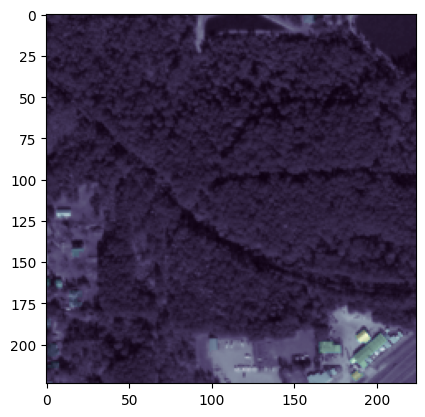

In [165]:
idx = random.choice(range(12))
plt.imshow(image_batch[idx][0], cmap='bone')
plt.imshow(mask_batch[idx][0], alpha=0.2)
plt.show()

## Model Training 

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNetModel(
  (encoder): ResNet(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [123]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for images, masks in dataloader:                # Assume your DataLoader returns (image, mask)
        images = images.to(device)                  # [B, 6, 224, 224]
        masks = masks.to(device)                    # [B, 224, 224] with values from 0 to 4
        masks = masks.long()

        optimizer.zero_grad()
        outputs = model(images)                      # [B, 5, 224, 224]
        loss = criterion(outputs, masks.squeeze(1))  # [B, H, W]
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{n_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/5] - Loss: 1.7320
Epoch [2/5] - Loss: 1.7312
Epoch [3/5] - Loss: 1.7318
Epoch [4/5] - Loss: 1.7322
Epoch [5/5] - Loss: 1.7296


## Model Evaluation

## Conversion of Output Mask to RGB .png File